In [ ]:
import os, pickle
import numpy as np


# ------------------------------------------------------------
# Load the processed, cropped data dict produced earlier
# ------------------------------------------------------------
pickle_path = 'output/processed_data_ori.pkl'
if not os.path.exists(pickle_path):
    raise FileNotFoundError(f"Processed data not found at {pickle_path}")

with open(pickle_path, 'rb') as f:
    data_dict = pickle.load(f)

# ------------------------------------------------------------
# Build the big data matrix X  (rows = slices, cols = time-bins)
# ------------------------------------------------------------
X_list, sample_tag = [], []
time_axis = None

for name, df in data_dict.items():
    if time_axis is None:
        time_axis = df['Time'].to_numpy(dtype=float)

    slice_cols  = df.columns.difference(['Time_index', 'Time'])
    mat         = df[slice_cols].to_numpy(dtype=float)      # (n_time, n_slices)
    X_list.append(mat.T)                                    # -> (n_slices, n_time)
    sample_tag.extend([name] * mat.shape[1])

X           = np.vstack(X_list)
n_slices, n_time = X.shape
print("Combined data matrix shape:", X.shape)

Combined data matrix shape: (216, 389)


Estimated taus: [  0.58407699   5.12468837 553.15643571]


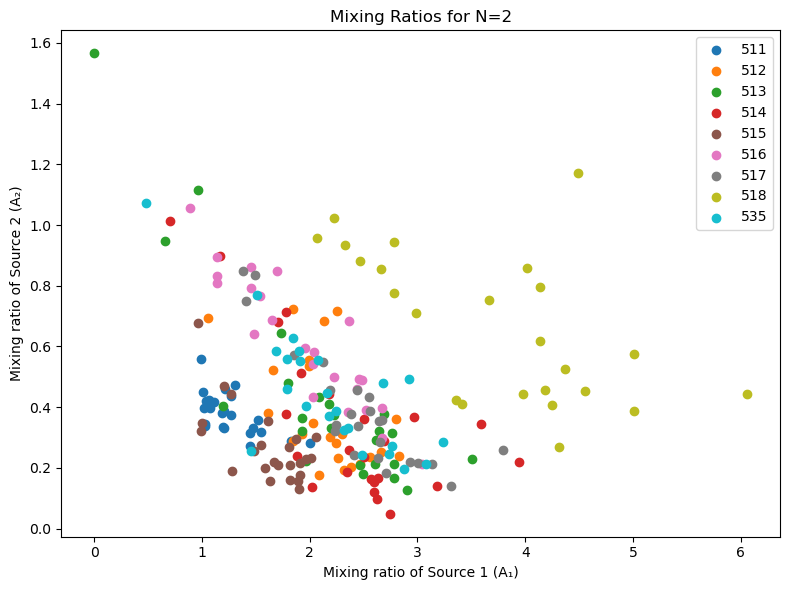

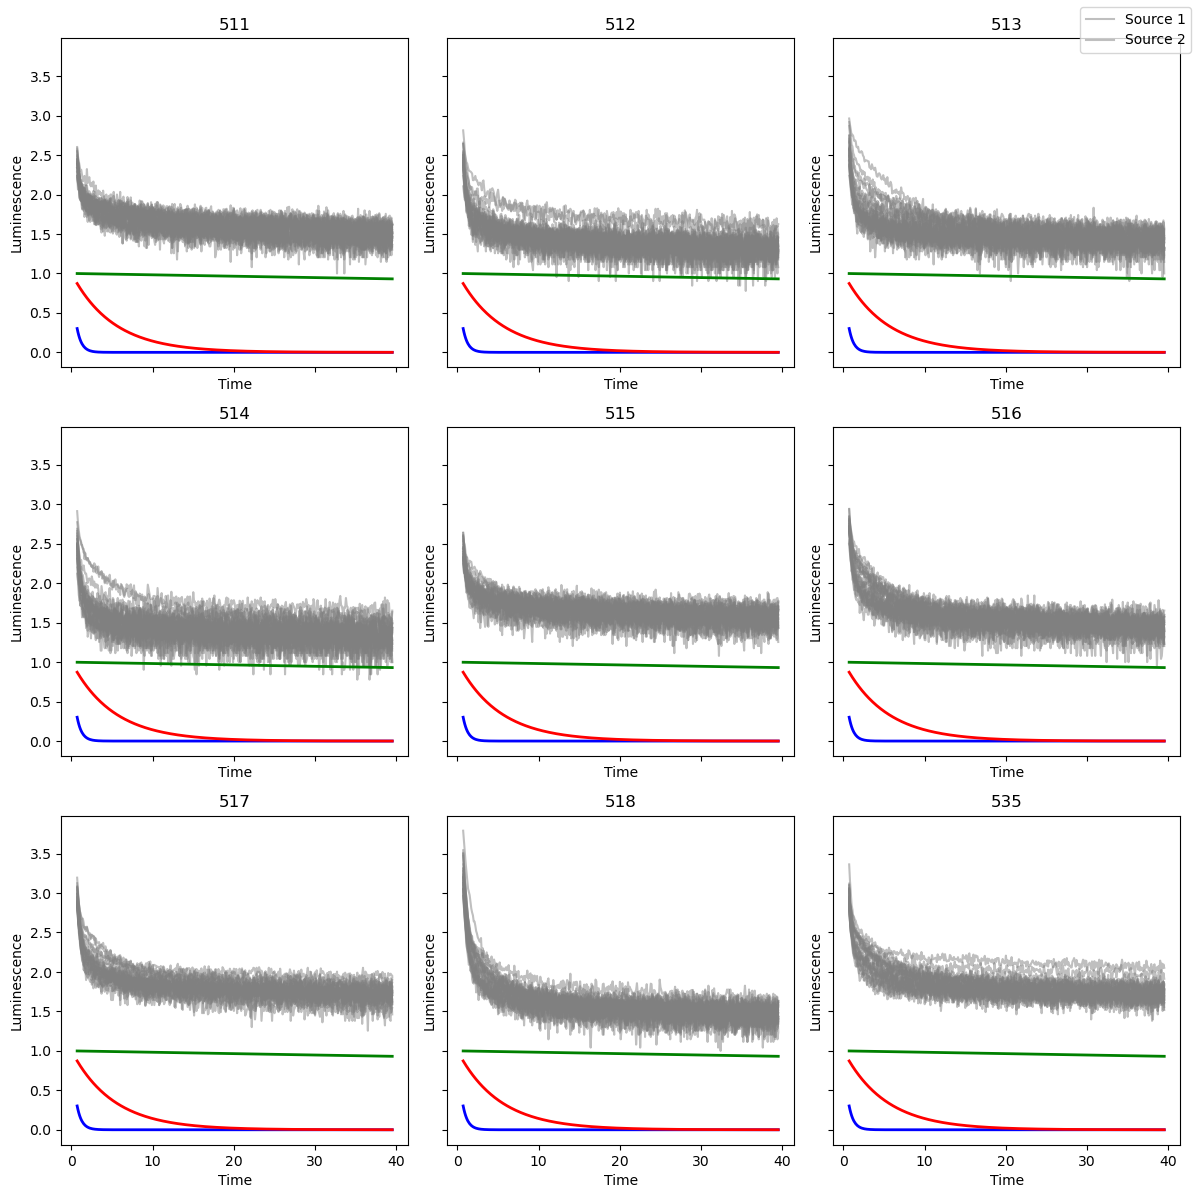

In [7]:
import os
import pickle
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. Load your data
# ------------------------------------------------------------
pickle_path = 'output/processed_data.pkl'   # adjust if needed
if not os.path.exists(pickle_path):
    raise FileNotFoundError(f"Processed data not found at {pickle_path}")
with open(pickle_path, 'rb') as f:
    data_dict = pickle.load(f)

# Build X (M slices × T time-bins), sample_tag list, and time_axis
X_list, sample_tag = [], []
time_axis = None
for name, df in data_dict.items():
    if time_axis is None:
        time_axis = df['Time'].to_numpy(dtype=float)
    slice_cols = df.columns.difference(['Time_index','Time'])
    mat = df[slice_cols].to_numpy(dtype=float)      # (T, n_slices)
    X_list.append(mat.T)                             # -> (n_slices, T)
    sample_tag.extend([name] * mat.shape[1])
X = np.vstack(X_list)  # shape (M, T)
sample_tag = np.array(sample_tag)
t = time_axis
M, T = X.shape

# ------------------------------------------------------------
# 2. Fit global 2-exponential model
#    d_j(t) ≈ A_{j1} e^{−t/τ1} + A_{j2} e^{−t/τ2}
# ------------------------------------------------------------
# N = 2

# def residuals(p):
#     taus = p[:N]
#     A = p[N:].reshape(M, N)
#     # source curves S_i(t) = exp(−t/τ_i)
#     S = np.exp(-np.outer(1/taus, t))   # (N, T)
#     D_hat = A.dot(S)                   # (M, T)
#     return (D_hat - X).ravel()

# # initial guesses
# tau0 = np.array([t.mean(), 2*t.mean()])
# A0 = np.tile(np.mean(X, axis=1, keepdims=True), (1, N)) / N
# p0 = np.hstack([tau0, A0.ravel()])

# # enforce τ>0 and A>=0
# lower = np.hstack([[1e-6]*N, np.zeros(M*N)])
# upper = np.inf * np.ones_like(p0)

# sol = least_squares(residuals, p0, bounds=(lower,upper))
# taus_est = sol.x[:N]
# A_est = sol.x[N:].reshape(M, N)

# print(f"Estimated time constants: τ₁ = {taus_est[0]:.2f},  τ₂ = {taus_est[1]:.2f}")




N = 3

def residuals(p):
    taus = p[:N]
    A = p[N:].reshape(M, N)
    # pure-source decays
    S = np.exp(-np.outer(1/taus, t))   # (N, T)
    D_hat = A.dot(S)                   # (M, T)
    return (D_hat - X).ravel()

# 1) initial guesses for τ (length N)
tau0 = np.array([t.mean(), 2*t.mean(), 3*t.mean()])

# 2) initial guesses for A (shape M×N)
A0 = np.tile(np.mean(X, axis=1, keepdims=True), (1, N)) / N

# 3) stack into p0 of length N + M*N
p0 = np.hstack([tau0, A0.ravel()])

# 4) bounds of same shape as p0
lower = np.hstack([[1e-6]*N, np.zeros(M*N)])
upper = np.inf * np.ones_like(p0)

# 5) solve
sol = least_squares(residuals, p0, bounds=(lower, upper))
taus_est = sol.x[:N]
A_est    = sol.x[N:].reshape(M, N)

print(f"Estimated taus: {taus_est}")

# ------------------------------------------------------------
# 3. Scatter plot of mixing ratios (A₁ vs. A₂), colored by sample
# ------------------------------------------------------------
unique_samples = np.unique(sample_tag)
colors = plt.cm.tab10(np.linspace(0,1,len(unique_samples)))

plt.figure(figsize=(8,6))
for c, s in zip(colors, unique_samples):
    mask = (sample_tag == s)
    plt.scatter(A_est[mask,0], A_est[mask,1], label=s, color=c)
plt.xlabel('Mixing ratio of Source 1 (A₁)')
plt.ylabel('Mixing ratio of Source 2 (A₂)')
plt.title('Mixing Ratios for N=2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 4. 3×3 subplots: raw slices (grey) + two source curves
# ------------------------------------------------------------
S_est = np.exp(-np.outer(1/taus_est, t))  # (2, T)

fig, axs = plt.subplots(3, 3, figsize=(12,12), sharex=True, sharey=True)
for ax, s in zip(axs.ravel(), unique_samples):
    mask = (sample_tag == s)
    # raw curves
    for j in np.where(mask)[0]:
        ax.plot(t, X[j], color='grey', alpha=0.5)
    # overlaid sources
    ax.plot(t, S_est[0], color='blue',  lw=2, label='Source 1')
    ax.plot(t, S_est[1], color='red',   lw=2, label='Source 2')
    ax.plot(t, S_est[2], color='green', lw=2, label='Source 3')

    ax.set_title(s)
    ax.set_xlabel('Time')
    ax.set_ylabel('Luminescence')

# shared legend for the two sources
fig.legend(['Source 1','Source 2'], loc='upper right')
plt.tight_layout()
plt.show()


In [8]:
import os
import pickle
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# 1) Load data
pickle_path = 'output/processed_data.pkl'
if not os.path.exists(pickle_path):
    raise FileNotFoundError(f"Processed data not found at {pickle_path}")
with open(pickle_path, 'rb') as f:
    data_dict = pickle.load(f)

# build X (M×T), sample tags, and time-axis t
X_list, sample_tag = [], []
t = None
for name, df in data_dict.items():
    if t is None:
        t = df['Time'].to_numpy(dtype=float)
    cols = df.columns.difference(['Time_index','Time'])
    mat = df[cols].to_numpy(dtype=float)   # (T, n_slices)
    X_list.append(mat.T)                   # -> (n_slices, T)
    sample_tag.extend([name]*mat.shape[1])

X = np.vstack(X_list)                      # (M, T)
sample_tag = np.array(sample_tag)
M, T = X.shape
N = 3  # number of exponentials

# 2) Define residuals with u-parameterization
def residuals(p):
    taus = p[:N]                                   # global τ_i >0
    u    = p[N:].reshape(M, N)                     # unconstrained
    B    = np.exp(u)                               # >0
    A    = B / (1 + B.sum(axis=1, keepdims=True))  # each row sums <1
    S    = np.exp(-np.outer(1/taus, t))            # (N, T)
    Dhat = A.dot(S)                                # (M, T)
    return (Dhat - X).ravel()

# 3) Initial guess: τ's and u's
tau0 = np.array([t.mean(), 2*t.mean(), 3*t.mean()])
u0   = np.zeros((M, N))    # B=1 -> A = 1/(1+N)
p0   = np.hstack([tau0, u0.ravel()])

# 4) Bounds: τ>0, u free
lower = np.hstack([[1e-6]*N, [-np.inf]*(M*N)])
upper = np.inf * np.ones_like(p0)

# 5) Solve
res = least_squares(residuals, p0, bounds=(lower,upper), max_nfev=2000)
taus_est = res.x[:N]
u_est    = res.x[N:].reshape(M, N)
B_est    = np.exp(u_est)
A_est    = B_est / (1 + B_est.sum(axis=1, keepdims=True))

print("Fitted taus:", taus_est)

# 6) Scatter plot of A[:,0] vs A[:,1]
unique = np.unique(sample_tag)
colors = plt.cm.tab10(np.linspace(0,1,len(unique)))
plt.figure(figsize=(8,6))
for c,s in zip(colors, unique):
    m = sample_tag==s
    plt.scatter(A_est[m,0], A_est[m,1], label=s, color=c)
plt.xlabel('A₁'); plt.ylabel('A₂')
plt.title('Mixing ratios (Method 1)')
plt.legend(); plt.tight_layout(); plt.show()

# 7) 3×3 subplots per sample
S_est = np.exp(-np.outer(1/taus_est, t))  # (3, T)
fig, axs = plt.subplots(3,3,figsize=(12,12),sharex=True,sharey=True)
for ax,s in zip(axs.ravel(), unique):
    m = sample_tag==s
    for j in np.where(m)[0]:
        ax.plot(t, X[j], color='grey', alpha=0.4)
    for i,col in zip(range(N), ['blue','red','green']):
        ax.plot(t, S_est[i], color=col, lw=2, label=f'Source {i+1}')
    ax.set_title(s)
    ax.set_xlabel('Time'); ax.set_ylabel('Luminescence')
fig.legend([f'Source {i+1}' for i in range(N)], loc='upper right')
plt.tight_layout(); plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_24816\1683576637.py:34: RuntimeWarning: overflow encountered in exp
  B    = np.exp(u)                               # >0
C:\Users\User\AppData\Local\Temp\ipykernel_24816\1683576637.py:35: RuntimeWarning: invalid value encountered in true_divide
  A    = B / (1 + B.sum(axis=1, keepdims=True))  # each row sums <1


: 

Fitted taus: [ 61110.06023539  88751.27637283 244401.53405609]


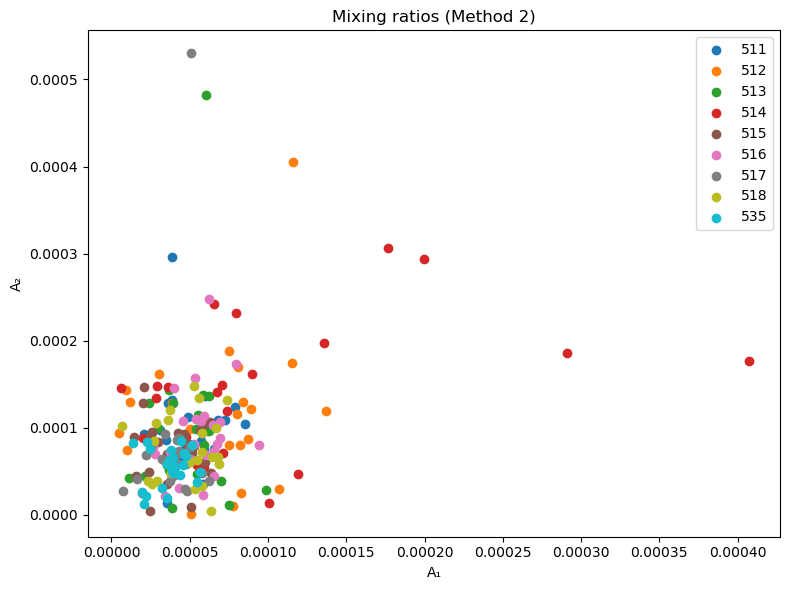

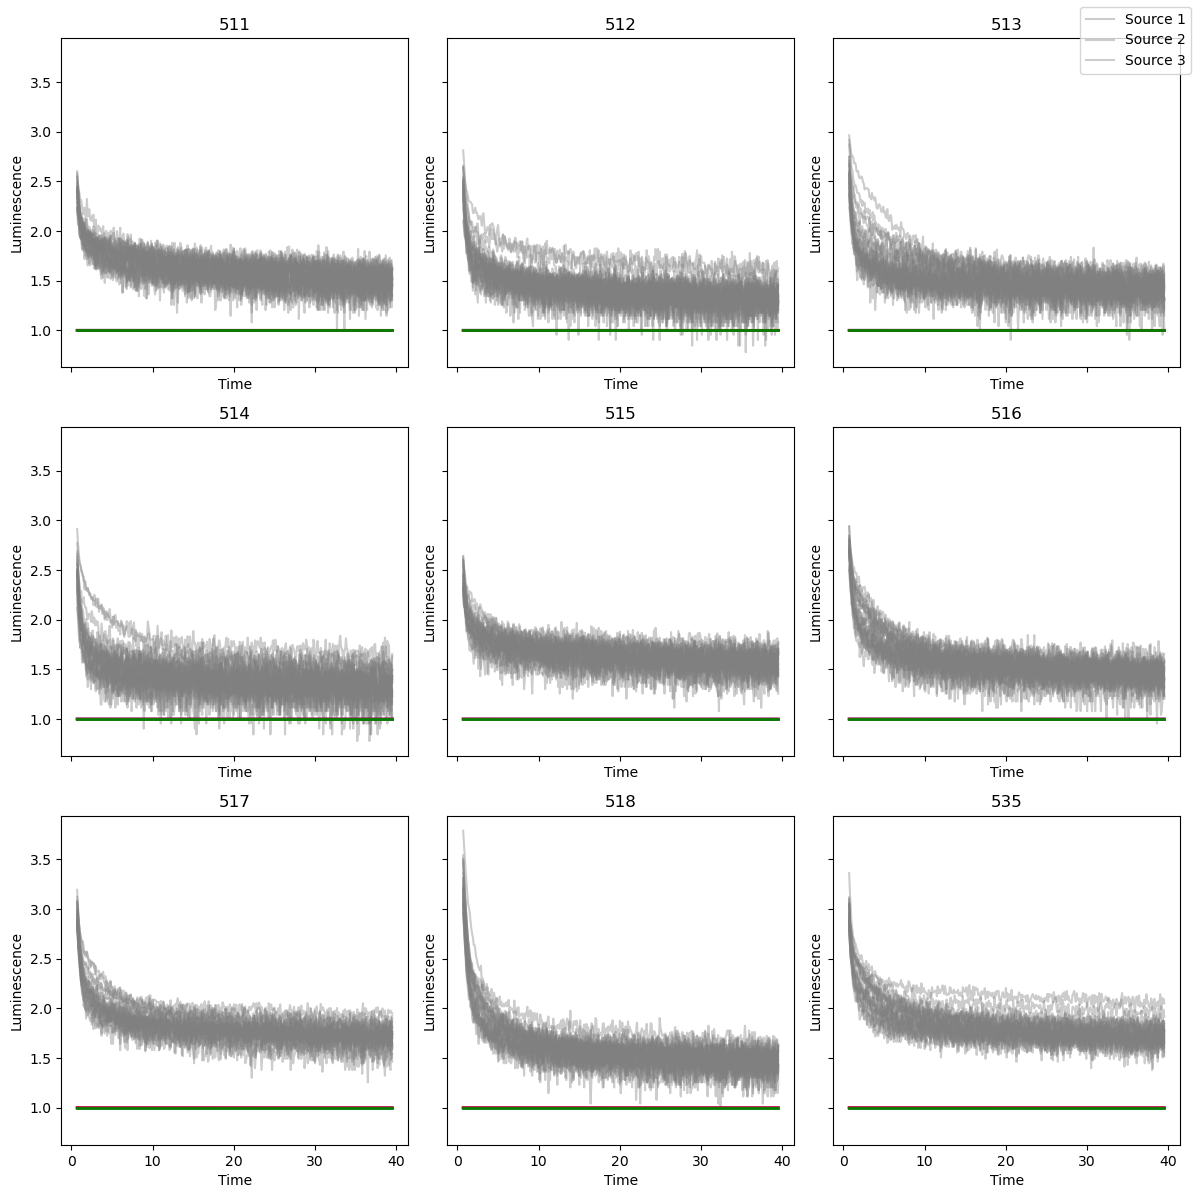

In [1]:
import os
import pickle
import numpy as np
from scipy.optimize import minimize, LinearConstraint
import matplotlib.pyplot as plt

# 1) Load data (same as above)
pickle_path = 'output/processed_data.pkl'
if not os.path.exists(pickle_path):
    raise FileNotFoundError(f"Processed data not found at {pickle_path}")
with open(pickle_path,'rb') as f:
    data_dict = pickle.load(f)

X_list, sample_tag = [], []
t = None
for name, df in data_dict.items():
    if t is None:
        t = df['Time'].to_numpy(dtype=float)
    cols = df.columns.difference(['Time_index','Time'])
    mat = df[cols].to_numpy(dtype=float)
    X_list.append(mat.T)
    sample_tag.extend([name]*mat.shape[1])

X = np.vstack(X_list)
sample_tag = np.array(sample_tag)
M, T = X.shape
N = 3

# 2) Residuals & objective
def residuals(p):
    taus = p[:N]
    A = p[N:].reshape(M,N)
    S = np.exp(-np.outer(1/taus, t))
    return (A.dot(S) - X).ravel()

def obj(p):
    r = residuals(p)
    return np.dot(r, r)

# 3) Initial guess & bounds
tau0 = np.array([t.mean(), 2*t.mean(), 3*t.mean()])
A0 = np.tile(np.mean(X,axis=1,keepdims=True),(1,N))/N
p0 = np.hstack([tau0, A0.ravel()])

bnds = [(1e-6, None)]*N + [(0, None)]*(M*N)

# 4) Build linear‐constraint: for each slice j, sum_i A[j,i] ≤ 1
L = np.zeros((M, N + M*N))
for j in range(M):
    start = N + j*N
    L[j, start:start+N] = 1
lc = LinearConstraint(L, lb=-np.inf, ub=np.ones(M))

# 5) Solve with trust‐constr
res = minimize(obj, p0,
               method='trust-constr',
               bounds=bnds,
               constraints=[lc],
               options={'maxiter':1000})
popt = res.x
taus_est = popt[:N]
A_est = popt[N:].reshape(M, N)
print("Fitted taus:", taus_est)

# 6) Scatter plot
unique = np.unique(sample_tag)
colors = plt.cm.tab10(np.linspace(0,1,len(unique)))
plt.figure(figsize=(8,6))
for c,s in zip(colors, unique):
    m = sample_tag==s
    plt.scatter(A_est[m,0], A_est[m,1], label=s, color=c)
plt.xlabel('A₁'); plt.ylabel('A₂')
plt.title('Mixing ratios (Method 2)')
plt.legend(); plt.tight_layout(); plt.show()

# 7) 3×3 subplots
S_est = np.exp(-np.outer(1/taus_est, t))
fig, axs = plt.subplots(3,3,figsize=(12,12),sharex=True,sharey=True)
for ax,s in zip(axs.ravel(), unique):
    m = sample_tag==s
    for j in np.where(m)[0]:
        ax.plot(t, X[j], color='grey', alpha=0.4)
    for i,col in zip(range(N), ['blue','red','green']):
        ax.plot(t, S_est[i], color=col, lw=2, label=f'Source {i+1}')
    ax.set_title(s)
    ax.set_xlabel('Time'); ax.set_ylabel('Luminescence')
fig.legend([f'Source {i+1}' for i in range(N)], loc='upper right')
plt.tight_layout(); plt.show()
